# <font style="color:blue">Project 3: Kaggle Competition - Semantic Segmentation</font>

#### Maximum Points: 100

<div>
    <table>
        <tr><td><h3>Sr. no.</h3></td> <td><h3>Section</h3></td> <td><h3>Points</h3></td> </tr>
        <tr><td><h3>1</h3></td> <td><h3>1.1. Dataset Class</h3></td> <td><h3>7</h3></td> </tr>
        <tr><td><h3>2</h3></td> <td><h3>1.2. Visualize dataset</h3></td> <td><h3>3</h3></td> </tr>
        <tr><td><h3>3</h3></td> <td><h3>2. Evaluation Metrics</h3></td> <td><h3>10</h3></td> </tr>
        <tr><td><h3>4</h3></td> <td><h3>3. Model</h3></td> <td><h3>10</h3></td> </tr>
        <tr><td><h3>5</h3></td> <td><h3>4.1. Train</h3></td> <td><h3>7</h3></td> </tr>
        <tr><td><h3>6</h3></td> <td><h3>4.2. Inference</h3></td> <td><h3>3</h3></td> </tr>
        <tr><td><h3>7</h3></td> <td><h3>5. Prepare Submission CSV</h3></td><td><h3>10</h3></td> </tr>
        <tr><td><h3>8</h3></td> <td><h3>6. Kaggle Profile Link</h3></td> <td><h3>50</h3></td> </tr>
    </table>
</div>

---

**In this project, you have participated in the Kaggle competition, and also submit the notebook and othe code in the course lab.**

**This Kaggle competition is a semantic segmentation challenge.**

<h2>Dataset Description </h2>
<p>The dataset consists of 3,269 images in 12 classes (including background). All images were taken from drones in a variety of scales. Samples are shown below:
<img src="https://www.dropbox.com/scl/fi/pswwraz1cc9srd9d4hxm3/data_montage.jpg?rlkey=074v9mc32et70ijl0dz3y0rvs&dl=1" width="800" height="800">
<p>The data was splitted into public train set and private test set which is used for evaluation of submissions. You can split public subset into train and validation sets yourself.
Images are named with a unique <code>ImageId</code>. </p>
<p> You should segment and classify the images in the test set.</p>
<p>The dataset consists of landscape images taken from drones in a variety of scales.</p>

**The notebook is divided into sections. You have to write code, as mention in the section.  For other helper functions, you can write `.py` files and import them in the notebook. You have to submit the notebook along with `.py` files. Your submitted code must be runnable without any bug.**

In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
from os.path import join
import pandas as pd
from dataclasses import dataclass
import cv2
import albumentations as A
import numpy as np
from rgb_segmentation import get_corresponding_Color
import torchvision
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
from torchsummary import summary
from tqdm import tqdm
# from transformers import AutoImageProcessor, SegformerForSemanticSegmentation

# <font style="color:green">1. Data Exploration</font>

In this section, you have to write your custom dataset class and visualize a few images (max five images) and its mask.

## <font style="color:green">1.1. Dataset Class [7 Points]</font>

**In this sub-section, write your custom dataset class.**


**Note that there are not separate validation data, so you will have to create your validation set by dividing train data into train and validation data. Usually, in practice, we do `80:20` ratio for train and validation, respectively.** 

**for example:**

```
class SemSegDataset(Dataset):
    """ Generic Dataset class for semantic segmentation datasets.

        Arguments:
            data_path (string): Path to the dataset folder.
            images_folder (string): Name of the folder containing the images (related to the data_path).
            masks_folder (string): Name of the folder containing the masks (related to the data_path).
            csv_path (string): train or test csv file name
            image_ids (list): List of images.
            train_val_test (string): 'train', 'val' or 'test'
            transforms (callable, optional): A function/transform that inputs a sample
                and returns its transformed version.
            class_names (list, optional): Names of the classes.
            

        Dataset folder structure:
            Folder containing the dataset should look like:
            - data_path
            -- images_folder
            -- masks_folder

            Names of images in the images_folder and masks_folder should be the same for same samples.
    """
```

In [4]:
torch.manual_seed(0)

In [5]:
class SemSegDataset(Dataset):
    
    def __init__(self,data_path,images_folder,masks_folder,csv_path,dataset_type,num_classes,validset_ratio,transform=None,class_names=None):
        self.data_path = data_path
        self.images_folder = images_folder
        self.masks_folder = masks_folder
        self.csv_path = csv_path
        self.dataset_type = dataset_type
        self.num_classes = num_classes
        self.transform = transform
        self.class_names = class_names

        
        self.image_ids = pd.read_csv(join(data_path,csv_path)).astype('str')
        if dataset_type == 'train' or dataset_type == 'valid':
            
            train_set = self.image_ids.sample(frac=1-validset_ratio)
            valid_set = self.image_ids.drop(train_set.index)
                           
            

            if dataset_type == 'train':
                self.dataset = train_set
            else:
                self.dataset = valid_set
                
        elif dataset_type == 'test':
            self.dataset = self.image_ids
        else:
            raise Exception("Wrong dataset type")

        self.dataset.reset_index(inplace=True,drop=True)


    def __len__(self):
        return len(self.dataset)
                  
    def __getitem__(self,index):
        img = cv2.cvtColor(cv2.imread(f"{join(self.images_folder,self.dataset.iloc[index]['ImageID'])}.jpg",cv2.IMREAD_UNCHANGED),cv2.COLOR_BGR2RGB)
        
        if self.dataset_type != 'test':
            mask = cv2.imread(f"{join(self.masks_folder,self.dataset.iloc[index]['ImageID'])}.png",cv2.IMREAD_UNCHANGED)

            if self.transform is not None:
                transformed = self.transform(image=img, mask=mask)
                return transformed['image'],transformed['mask']
            else:
                return img,mask
        else:
            if self.transform is not None:
                return self.transform(image=img)['image']
            else:
                return img
            
            

In [6]:
@dataclass
class DatasetInfo:
    data_path:str
    images_folder:str
    masks_folder:str
    train_file:str
    test_file:str
    num_classes:int
    validset_ratio:float
    mean:list[float]
    std:list[float]
    class_names:list[str]
    class_wieghts:list[float]
    
    
    

In [7]:
@dataclass
class TrainingConfiguration:
    epochs:int
    batch_size:int
    lr:float
    weight_decay:float
    pretrained:bool
    optimizer:str
    criterion:str
    transform:A.Compose
    

In [8]:
datasetInfo = DatasetInfo(
    data_path=r'C:\Users\falmasridev\Documents\opencv_courses\c2\opencv-pytorch-segmentation-project-round2',
    images_folder=r'C:\Users\falmasridev\Documents\opencv_courses\c2\opencv-pytorch-segmentation-project-round2\imgs\imgs',
    masks_folder=r'C:\Users\falmasridev\Documents\opencv_courses\c2\opencv-pytorch-segmentation-project-round2\masks\masks',
    train_file=r'C:\Users\falmasridev\Documents\opencv_courses\c2\opencv-pytorch-segmentation-project-round2\train.csv',
    test_file=r'C:\Users\falmasridev\Documents\opencv_courses\c2\opencv-pytorch-segmentation-project-round2\test.csv',
    num_classes=12,
    validset_ratio=0.21,
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225],
    class_names=['Background','Person','Bike','Car','Drone','Boat','Animal','Obstacle','Construction','Vegetation','Road','Sky'],
    class_wieghts=[]

)

In [9]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(15),
    A.ElasticTransform(),
    A.Normalize(datasetInfo.mean, datasetInfo.std),
    A.ToTensorV2()
])

test_transform = A.Compose([
    A.Normalize(datasetInfo.mean, datasetInfo.std),
    A.ToTensorV2()
])

In [11]:
trainingConfiguration = TrainingConfiguration(
    epochs=50,
    batch_size=4,
    lr=0.001,
    weight_decay=0,
    pretrained=True,
    optimizer="Adam",
    criterion="crossEntropy",
    transform=transform,
)

In [129]:
# train_set = SemSegDataset(
#     data_path=datasetInfo.data_path,
#     images_folder=datasetInfo.images_folder,
#     masks_folder=datasetInfo.masks_folder,
#     csv_path=datasetInfo.train_file,
#     dataset_type='train',
#     num_classes=datasetInfo.num_classes,
#     validset_ratio=datasetInfo.validset_ratio,
#     transform=transform,
#     class_names=datasetInfo.class_names
# )

valid_set = SemSegDataset(
    data_path=datasetInfo.data_path,
    images_folder=datasetInfo.images_folder,
    masks_folder=datasetInfo.masks_folder,
    csv_path=datasetInfo.train_file,
    dataset_type='valid',
    num_classes=datasetInfo.num_classes,
    validset_ratio=datasetInfo.validset_ratio,
    transform=test_transform,
    class_names=datasetInfo.class_names
)

test_set = SemSegDataset(
    data_path=datasetInfo.data_path,
    images_folder=datasetInfo.images_folder,
    masks_folder=datasetInfo.masks_folder,
    csv_path=datasetInfo.test_file,
    dataset_type='test',
    num_classes=datasetInfo.num_classes,
    validset_ratio=datasetInfo.validset_ratio,
    transform=test_transform,
    class_names=datasetInfo.class_names
)

In [133]:
len(train_set),len(valid_set),len(test_set)

NameError: name 'train_set' is not defined

In [138]:
#cpu_count=16

#Kindly Note: multiprocessing is not working in Jupyter with Windows. So If you want to experiment here, num_workers must equals 0.
# # I attached a train.py version for multiproceesing :)
# train_loader = DataLoader(train_set,batch_size=trainingConfiguration.batch_size,shuffle=True,num_workers=0,persistent_workers=False)
valid_loader = DataLoader(valid_set,batch_size=trainingConfiguration.batch_size,shuffle=False,num_workers=0,persistent_workers=False,drop_last=True)
test_loader = DataLoader(test_set,batch_size=trainingConfiguration.batch_size,shuffle=False,num_workers=0,persistent_workers=False)

In [15]:
# len(train_loader),len(valid_loader),
len(test_loader)

162

In [16]:
for images in test_loader:
    print(images.shape)
    break

torch.Size([4, 3, 720, 1280])


In [21]:
imgs = next(iter(test_loader))

In [ ]:
mean = torch.zeros(3)
std = torch.zeros(3)
num_samples = 0
pixel_count = 0

for imgs, _ in train_loader:
    batch_size = imgs.shape[0]
    num_samples += batch_size
    pixels_per_batch = batch_size * imgs.shape[2] * imgs.shape[3]
    pixel_count += pixels_per_batch
    
    # Sum across all dimensions except the channel dimension
    mean += imgs.sum(dim=[0, 2, 3])
    # Sum of squares for variance calculation
    std += (imgs ** 2).sum(dim=[0, 2, 3])

# Divide by total number of pixels
mean /= pixel_count
# Calculate std using: std = sqrt(E[X²] - E[X]²)
std = torch.sqrt(std/pixel_count - mean**2)

print("Mean:", mean)
print("Std:", std)

In [ ]:
from fipy.segmentation_distribution_analysis import get_pixels_frequency

In [ ]:
train_dist = get_pixels_frequency(train_set,visualize=True)
valid_dist = get_pixels_frequency(valid_set,visualize=True)

In [ ]:
df = pd.DataFrame(train_dist)
df.columns = datasetInfo.class_names
df

In [ ]:
epsilon = 5e-1
result_weights =((1 - (df.loc['number_of_images'] / len(train_set)))+1) * (np.log10(df.loc['counted_pixels'].max() / df.loc['counted_pixels']) ) + epsilon
datasetInfo.class_wieghts = result_weights
print(list(result_weights))

In [ ]:
[0.5,2,2,2,2,2,2,2,2,0.5,0.5,0]

In [ ]:
valid_dist

## <font style="color:green">1.2. Visualize dataset [3 Points]</font>

**In this sub-section,  you have to plot a few images and its mask.**

**for example:**

---

<img src="https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w12-data-sample.png">

---

In [170]:
def visualize_mask(image,mask,show_prediction=False,model=None):
    plt.figure(figsize=(10,10))
    img = image.permute((1,2,0))
    
    rgb_mask = get_corresponding_Color(mask)
    
    plt.subplot(1,3,1)
    plt.title('image')
    plt.imshow(img)
    
    plt.subplot(1,3,2)
    plt.title('Mask')
    plt.imshow(rgb_mask)
    if show_prediction:
        plt.subplot(1,3,3)
        plt.title('Prediction')
        plt.imshow(get_corresponding_Color(inference(model,image)))


In [171]:
def visulize_samples(n_samples,dataset,mean=torch.tensor([0.485, 0.456, 0.406]), std=torch.tensor([0.229, 0.224, 0.225]),show_predictions=False,model=None):
    random_samples = torch.randint(0,len(dataset),(n_samples,))
    for i in random_samples:
        img,mask = dataset[i.item()]
        unnoramlized_img = torch.mul(img,std.view(3,1,1)) + mean.view(3,1,1)
        visualize_mask(unnoramlized_img,mask,show_predictions,model)
        

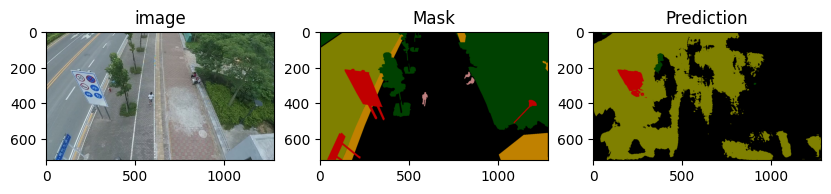

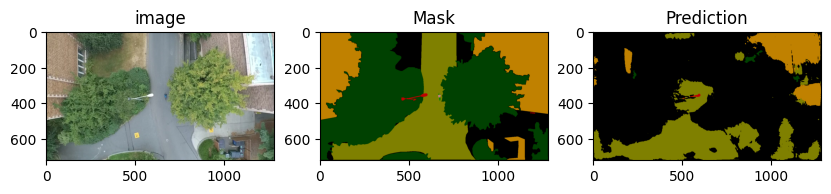

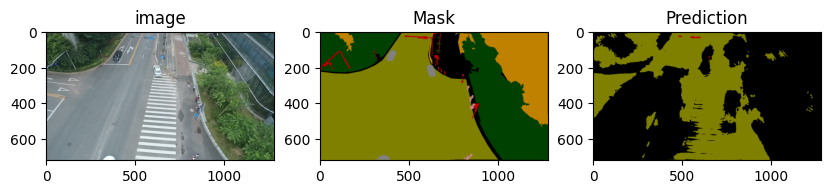

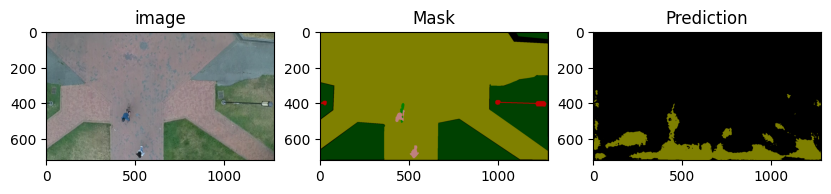

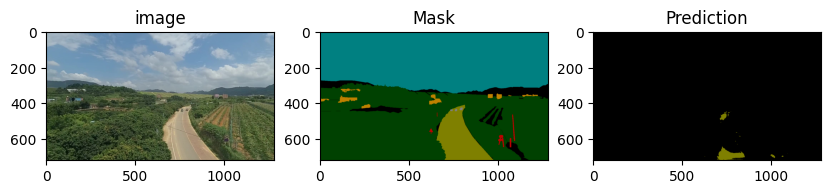

In [172]:
visulize_samples(5,valid_set,show_predictions=True,model=model)

In [18]:
import segmentation_models_pytorch as smp

In [173]:
model = smp.from_pretrained(r"C:\Users\falmasridev\Documents\opencv_courses\c2\opencv-pytorch-segmentation-project-round2\exp16_Segformer_best",local_files_only=True)
model.eval()


Loading weights from local directory


DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

# <font style="color:green">2. Evaluation Metrics [10 Points]</font>

<p>This competition is evaluated on the mean <a href='https://en.wikipedia.org/wiki/Sørensen–Dice_coefficient'>Dice coefficient</a
>. The Dice coefficient can be used to compare the pixel-wise agreement between a predicted segmentation and its corresponding ground truth. The formula is given by: </p>

<p>$$DSC =  \frac{2 |X \cap Y|}{|X|+ |Y|}$$
$$ \small \mathrm{where}\ X = Predicted\ Set\ of\ Pixels,\ \ Y = Ground\ Truth $$ </p>
<p>The Dice coefficient is defined to be 1 when both X and Y are empty.</p>

**In this section, you have to implement the dice coefficient evaluation metric.**

In [ ]:
def dice_coefficient(prediction,ground_truth,num_classes=12,smooth=1e-8):
    """ 
    The function calculates the F1 evaluation metric which used in the competation.

    Params:
    prediction: Shape(batch_size X Height X Width) predicted segmenation
    ground_truth: Shape(batch_size X Height X Width) representing the truth segmenation.

    return: the function returns the similarity between the masks which is 1 if they are fully matched.
    """
    
    pred_one_hot = nn.functional.one_hot(prediction, num_classes=num_classes).float()  # Shape: (batch_size, height, width, num_classes)
    gt_one_hot = nn.functional.one_hot(ground_truth, num_classes=num_classes).float()  # Shape: (batch_size, height, width, num_classes)
    intersection = torch.sum(pred_one_hot * gt_one_hot, dim=(0, 1, 2))  # Shape: (num_classes,)
    union = torch.sum(pred_one_hot, dim=(0, 1, 2)) + torch.sum(gt_one_hot, dim=(0, 1, 2))  # Shape: (num_classes,)
# Compute dice only for valid classes
    valid_classes = union > 0
    dice_per_class = torch.zeros(num_classes)  # Default to 0
    dice_per_class[valid_classes] = (2.0 * intersection[valid_classes]) / (union[valid_classes] + smooth)
    
    if valid_classes.sum() == 0:
        return 0.0  # If no valid classes, return 0 instead of NaN

    return dice_per_class[valid_classes].mean().item()

In [ ]:
#example:
dummy_input = torch.unsqueeze(torch.ones((1000,),dtype=torch.long),dim=0,).view(250,2,2) 
dummy_ground_truth = torch.unsqueeze(torch.ones((1000,),dtype=torch.long),dim=0,).view(250,2,2)
# print(f"Prediction: {dummy_input}\nGround Truth: {dummy_ground_truth}")
dice_coefficient(dummy_input,dummy_ground_truth)

In [ ]:
def iou(prediction, ground_truth, n_classes=12):
    """
    args:
        prediction: shape(batch_size X Height X Width)
        ground_truth: Shape(batch_size X Height X Width)
    """
    ious = []
    prediction = prediction.view(-1)
    ground_truth = ground_truth.view(-1)

    for cls in range(n_classes):  # Iterate over all classes
        pred_inds = prediction == cls
        ground_truth_inds = ground_truth == cls

        intersection = (pred_inds & ground_truth_inds).sum().item()
        union = pred_inds.sum().item() + ground_truth_inds.sum().item() - intersection

        if union == 0:
            ious.append(0)  # Avoid division by zero
        else:
            ious.append(float(intersection) / float(union))
    
    return torch.tensor(ious)


In [ ]:
def mean_iou(ious,n_classes=12):
    return torch.sum(ious) / (ious > 0).sum() if  (ious > 0).sum()  != 0 else 1

In [ ]:
iou_per_class = iou(dummy_input,dummy_ground_truth)
mean_iou = mean_iou(iou_per_class)

print(f"iou for each class: {iou_per_class}\nmean IOU: {mean_iou}")

# <font style="color:green">3. Model [10 Points]</font>

**In this section, you have to define your model.**

In [9]:

model = torchvision.models.segmentation.deeplabv3_resnet50(torchvision.models.segmentation.DeepLabV3_ResNet50_Weights.DEFAULT)
model.classifier[4] = nn.Conv2d(256, datasetInfo.num_classes, kernel_size=(1, 1), stride=(1, 1))

C:\Users\falmasridev\.conda\envs\cv-env\Lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [ ]:
model.

In [ ]:
model.classifier[4]

In [ ]:
def params_status(model,freeze=False):
    for param in model.parameters():
        param.requires_grad = not freeze
    

params_status(model,True)

In [ ]:
model.classifier[4] = nn.Conv2d(256,datasetInfo.num_classes,kernel_size=(1,1),stride=(1,1))
params_status(model.classifier,False)

In [ ]:
model.aux_classifier

In [ ]:
model.aux_classifier[4] =  nn.Conv2d(10,datasetInfo.num_classes,kernel_size=(1,1),stride=(1,1))

In [10]:
model.load_state_dict(torch.load('./exp11_final_sub_deeplap_layer4_unfreezed.pth'))

<All keys matched successfully>

In [ ]:
summary(model)

# <font style="color:green">4. Train & Inference</font>

- **In this section, you have to train the model and infer on sample data.**


- **You can write your trainer class in this section.**


- **If you are using any loss function other than PyTorch standard loss function, you have to define in this section.**


- **This section should also have optimizer and LR-schedular (if using) details.**



## <font style="color:green">4.1. Train [7 Points]</font>

**Write your training code in this sub-section.**


**This section must contain training plots (use matplotlib or share tensorboard.dev scalars logs).**

**You must have to plot the following:**
- **train loss**


- **validation loss**


- **IoU for all twelve classes (0-11) and the mean IoU of all classes on validatin data.** 

**an example of matplotlib plot:**

---

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w12-train-loss.png'>

---

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w12-val-loss.png'>

---

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w12-mean_iou.png'>

---

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w12-iou-0.png'>

---

<center>*</center>
<center>*</center>
<center>*</center>

---

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w12-iou-11.png'>

---


In [ ]:
writer = SummaryWriter('runs/')


In [ ]:
writer.add_text("training Configuration",f"{trainingConfiguration}")

In [ ]:
import os
print(os.listdir(f'runs/{trainingConfiguration.experiment_name}'))

In [ ]:
writer.add_graph(model,torch.unsqueeze(train_set[0][0],0),use_strict_trace=False)

In [ ]:
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [ ]:
def train(trainingConfiguration,
            class_names,
            train_loader,
            valid_loader,
            model,
            criterion,
            optimizer:torch.optim,
            tb_writer:SummaryWriter,
            num_classes=12):
        
        model = model.to('cuda')
        
        for e in range(1,trainingConfiguration.epochs+1):
            model = model.train()
            training_loss = 0
            running_iou = torch.zeros(num_classes,device='cuda')
            dc = 0
            for images,masks in tqdm(train_loader,desc='Training:',total=len(train_loader)):
                optimizer.zero_grad()
                
                images = images.to('cuda')
                masks = masks.to('cuda').long()
                with torch.amp.autocast('cuda'):
                    output = model(images)
                    highest_classes = output['out'].argmax(dim=1)
                    loss = criterion(output['out'], masks) + 0.2 * criterion(output['aux'], masks) + (1 - dice_coefficient(highest_classes, masks))

                loss.backward()
                optimizer.step()

                training_loss += loss.item()
                running_iou += iou(highest_classes,masks)
                dc += dice_coefficient(highest_classes,masks)
                
            training_loss /= len(train_loader)
            running_iou  /= len(train_loader)
            dc /= len(train_loader)
            
            tb_writer.add_scalar('Loss/train',training_loss,e)
            tb_writer.add_scalars('iou_per_class/training',{class_names[i]:running_iou[i].item() for i in range(num_classes)},e)
            tb_writer.add_scalar('Metrics/mean_iou/training',mean_iou(running_iou),e)
            tb_writer.add_scalar('Metrics/mean_dice_coefficient/training',dc,e)
            validate(class_names,valid_loader,model,criterion,tb_writer,e)


In [ ]:
def validate(class_names,valid_loader,model,criterion,tb_writer,e,num_classes=12):
        model = model.to('cuda')
        model = model.eval()
        running_loss = 0
        running_iou = torch.zeros(num_classes,device='cuda')
        dc = 0
        with torch.no_grad():
        
            for images,masks in tqdm(valid_loader,desc="Validation: ",total=len(valid_loader)):
                images = images.to('cuda')
                masks = masks.to('cuda').long()
                output = model(images)
                highest_classes = output['out'].argmax(dim=1)
                loss = criterion(output['out'], masks.long()) + 0.2 * criterion(output['aux'], masks.long()) + (1 - dice_coefficient(highest_classes, masks.long()))

                running_loss += loss.item()
                running_iou += iou(highest_classes,masks)
                dc += dice_coefficient(highest_classes,masks)

            running_loss /= len(valid_loader)
            running_iou  /= len(valid_loader)
            dc /= len(valid_loader)
            tb_writer.add_scalar('Loss/validation',running_loss,e)
            tb_writer.add_scalars('iou_per_class/validation',{class_names[i]:running_iou[i].item() for i in range(num_classes)},e)
            tb_writer.add_scalar('Metrics/mean_iou/validation',mean_iou(running_iou),e)
            tb_writer.add_scalar('Metrics/mean_dice_coefficient/validation',dc,e)


## <font style="color:green">4.2. Inference [3 Points]</font>

**Plot some sample inference in this sub-section.**

**for example:**

---

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w12-sample-predtiction.png'>

---



In [81]:
def inference(model,image):
    with torch.no_grad():
            output,_ = model(torch.unsqueeze(image,0))
            highest_classes = output.argmax(dim=1)
            
            return torch.squeeze(highest_classes,dim=0)
                

In [165]:
i = 2
visulize_samples(5,valid_set,True,model)

AttributeError: 'DeepLabV3Plus' object has no attribute 'view'

# <font style="color:green">5. Prepare Submission CSV [10 Points]</font>

**Write your code to prepare the submission CSV file.**


**Note that in the submission file, you have to write Encoded Pixels.**

[Here is a blog to understand what is Encoded Pixels.](https://medium.com/analytics-vidhya/generating-masks-from-encoded-pixels-semantic-segmentation-18635e834ad0)

In [12]:
model = model.eval()

In [146]:
def run_length_encoding(prediction,num_classes=12):
    classes_rle = {i:{'locations':[],'counts':[]} for i in range(num_classes)}
    
    prediction = prediction.numpy().flatten(order='F')
    count = 0
    current_class = prediction[0]
    beggining_index = 0

    for i in range(0,len(prediction)):
                
        if current_class == prediction[i]:                
            count += 1
            
        else:

            classes_rle[current_class]['locations'].append(beggining_index)
            classes_rle[current_class]['counts'].append(count)
            count = 1
            current_class = prediction[i]
            beggining_index = i


    classes_rle[current_class]['counts'].append(count)
    classes_rle[current_class]['locations'].append(beggining_index)

        

    

    return classes_rle
        
            
            

In [147]:
def get_rle_vectors(classes_rle):
    vectors = []
    for i in range(datasetInfo.num_classes):
        embeded_vector = ""
        for j in range(len(classes_rle[i]['locations'])):
            embeded_vector += f"{classes_rle[i]['locations'][j]} {classes_rle[i]['counts'][j]} "
        vectors.append(embeded_vector)
    return vectors

In [86]:
ids_list = []
for i in range(len(test_set)):
    for j in range(datasetInfo.num_classes):
        ids_list.append(f"{test_set.image_ids.iloc[i]['ImageID']}_{j}")

In [148]:
len(ids_list)

7776

In [174]:
encodedPixels = []
for i in range(len(test_set)):
    prediction = inference(model,test_set[i])
    vectors = get_rle_vectors(run_length_encoding(prediction))
    for v in vectors:
        encodedPixels.append(v)
    print(f"vector {i}/{len(test_set)} finished")
    

vector 0/648 finished
vector 1/648 finished
vector 2/648 finished
vector 3/648 finished
vector 4/648 finished
vector 5/648 finished
vector 6/648 finished
vector 7/648 finished
vector 8/648 finished
vector 9/648 finished
vector 10/648 finished
vector 11/648 finished
vector 12/648 finished
vector 13/648 finished
vector 14/648 finished
vector 15/648 finished
vector 16/648 finished
vector 17/648 finished
vector 18/648 finished
vector 19/648 finished
vector 20/648 finished
vector 21/648 finished
vector 22/648 finished
vector 23/648 finished
vector 24/648 finished
vector 25/648 finished
vector 26/648 finished
vector 27/648 finished
vector 28/648 finished
vector 29/648 finished
vector 30/648 finished
vector 31/648 finished
vector 32/648 finished
vector 33/648 finished
vector 34/648 finished
vector 35/648 finished
vector 36/648 finished
vector 37/648 finished
vector 38/648 finished
vector 39/648 finished
vector 40/648 finished
vector 41/648 finished
vector 42/648 finished
vector 43/648 finishe

In [175]:
len(encodedPixels)

7776

In [176]:
df = pd.DataFrame({'ImageID':ids_list,"EncodedPixels":encodedPixels},dtype=str)

In [177]:
df.to_csv('exp16_epoch_55.csv', index=False)

# <font style="color:green">6. Kaggle Profile Link [50 Points]</font>

Share your Kaggle profile link here with us so that we can give points for the competition score. 

You should have a minimum dice score of `0.60` on the test data to get all points. If the dice score is less than `0.55`, you will not get any points for the section. 

**You must have to submit `submission.csv` (prediction for images in `test.csv`) in `Submit Predictions` tab in Kaggle to get any evaluation in this section.**

In [ ]:
!jupyter nbconvert --to script Project3-Semantic-Segmentation_Starter_Round2.ipynb